# Embedding methods to augment with dynamic analysis

- tf-idf (term frequency - inverse document frequency)
- LDA (Latent Dirichlet Allocation)
- LSA (Latent Semantic Analysis)
- word2vec
- doc2vec

In [1]:
import os
import json
import pandas as pd
import numpy as np
import re
import nltk
import std_func

data_t = pd.read_csv("data/timeseries_data.csv")
data =  pd.read_csv("data/preprocessed.csv")
data_t.head(2)

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,reports
0,0,2017-06-29 20:05:22 UTC,2017-04-01,financialEntities/params;cik=1164888,m2.properties 4 item3.legalproceedings 4 ite...,1164888,m2.properties 4 item3.legalproceedings 4 item4...,disclosure part iiitem marketfor registrant co...,3
1,1,2016-03-03 17:53:54 UTC,2016-02-01,financialEntities/params;cik=1637459,l kraft heinz is one of the largest food and b...,1637459,l kraft heinz is one of the largest food and b...,l kraft heinz one largest food beverage compan...,3


In [2]:
data.head(2) # imported because i want names

,Unnamed: 0,accessionNumber,filingDate,reportingDate,financialEntity,htmlFile,coDescription,CIK,name,countryinc,cityma,SIC,SIC_desc,coDescription_lemmatized,coDescription_stopwords
0,0,0001441816-18-000028,2018-03-30 20:12:23 UTC,2018-02-01,financialEntities/params;cik=1441816,https://www.sec.gov/Archives/edgar/data/144181...,"mongodb is the leading modern, general purpose...",1441816,"MONGODB, INC.",US,NEW YORK,7372,Prepackaged Software (mass reproduction of sof...,"mongodb is the leading modern , general purpos...",mongodb leading modern general purpose databas...
1,1,0001108524-18-000011,2018-03-09 22:01:46 UTC,2018-02-01,financialEntities/params;cik=1108524,https://www.sec.gov/Archives/edgar/data/110852...,salesforce is a global leader in customer rela...,1108524,SALESFORCE COM INC,US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...,salesforce is a global leader in customer rela...,salesforce global leader customer relationship...


In [3]:
the_five = pd.DataFrame.from_dict(
    {1660134:"OKTA",1713683:"Z-Scaler",1065280:"NFLX",51143:"IBM",40545:"GE"},
    orient = "index").reset_index().rename(columns={"index":"CIK",0:"name"})

data_five_raw = pd.read_csv("data/bq_dynamic_five.csv")
data_five_raw["CIK"] = data_five_raw["financialEntity"].str.split("=", expand = True).iloc[:,1]
data_five = std_func.clean(data_five_raw)
data_five.head()

,filingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords
0,2008-02-28T00:42:30Z,financialEntities/params;cik=1065280,we are the largest online movie rentalsubscrip...,1065280,we are the largest online movie rentalsubscrip...,largest online movie rentalsubscription servic...
1,2009-02-25T21:22:45Z,financialEntities/params;cik=1065280,"with more than 10 millionsubscribers, we are t...",1065280,"with more than 10 millionsubscribers , we are ...",millionsubscribers largest online movie rental...
2,2010-02-22T19:09:32Z,financialEntities/params;cik=1065280,"with more than12 million subscribers, we are t...",1065280,"with more than12 million subscriber , we are t...",million subscriber world largest subscription ...
3,2011-02-18T19:42:40Z,financialEntities/params;cik=1065280,us with 20 million subscribers as of december ...,1065280,u with 20 million subscriber a of december 31 ...,u million subscriber december netflix netflix ...
4,2012-02-10T22:29:24Z,financialEntities/params;cik=1065280,"us netflix inc. (“netflix”, “the company”, “we...",1065280,"u netflix inc. ( “ netflix ” , “ the company ”...",u netflix netflix company u world leading inte...


In [4]:
# The companies with names have them, the ones that don't are NaN
clean = pd.merge(
    pd.merge(data_t,data.loc[:,["CIK","name"]], how = "left", on = "CIK"),
    the_five, how = "left", on="CIK")

clean['name'] = clean['name_y'].fillna(clean['name_x'])
clean = clean.drop(["name_x","name_y","reports"],axis = 1)
clean.head()

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,name
0,0,2017-06-29 20:05:22 UTC,2017-04-01,financialEntities/params;cik=1164888,m2.properties 4 item3.legalproceedings 4 ite...,1164888,m2.properties 4 item3.legalproceedings 4 item4...,disclosure part iiitem marketfor registrant co...,NaN
1,1,2016-03-03 17:53:54 UTC,2016-02-01,financialEntities/params;cik=1637459,l kraft heinz is one of the largest food and b...,1637459,l kraft heinz is one of the largest food and b...,l kraft heinz one largest food beverage compan...,NaN
2,2,2018-05-25 01:55:42 UTC,2018-04-01,financialEntities/params;cik=1302215,"established in 1972, houlihan lokey, inc., is ...",1302215,"established in 1972 , houlihan lokey , inc. , ...",established houlihan lokey leading global inde...,NaN
3,3,2018-12-19 22:01:54 UTC,2018-10-01,financialEntities/params;cik=725363,solved seccomments none item2.properties cel-s...,725363,solved seccomments none item2.properties cel-s...,solved seccomments none office space boone blv...,NaN
4,4,2018-02-28 18:47:50 UTC,2018-01-01,financialEntities/params;cik=103379,"orporation, organized in 1899, is a global lea...",103379,"orporation , organized in 1899 , is a global l...",orporation organized global leader design prod...,NaN


In [5]:
final = pd.concat([clean,data_five], axis = 0)
final = final.merge(pd.Series(final.groupby("CIK").size(), name = "reports"), how = "left", on = "CIK").sort_values(["CIK","filingDate"]).reset_index()
final.head()

,index,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,name,reports
0,836,823.0,2016-11-21 18:23:28 UTC,2016-10-01,financialEntities/params;cik=2969,al description of business air products and ch...,2969,al description of business air product and che...,al description business air product chemical u...,NaN,2
1,781,769.0,2018-11-20 19:47:42 UTC,2018-10-01,financialEntities/params;cik=2969,"ducts and chemicals, inc., a delaware corporat...",2969,"duct and chemical , inc. , a delaware corporat...",duct chemical delaware corporation originally ...,NaN,2
2,1972,1948.0,2016-12-06 22:05:12 UTC,2016-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”), was incorporated under ...",3545,"alico , inc. ( “ alico ” ) , wa incorporated u...",alico alico wa incorporated law state florida ...,NaN,3
3,1474,1456.0,2017-12-11 22:13:06 UTC,2017-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,NaN,3
4,86,83.0,2018-12-06 21:58:38 UTC,2018-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,NaN,3


## Diving into the embeddings

### tf-idf (term frequency - inverse document frequency)

In [456]:
import functools
import operator
from datetime import datetime

def deltas(final, embedding, features):
    ignore_words = ["revenue","fiscal","year", "operating", "december", "ended", "administrative", "month", "company", "general", "also",
                    "statement", "asset", "result", "term", "september", "accounting", "million"]
    changes = [[],[],[],[]]
    for i in final.loc[:,"CIK"]:
        # i = final.loc[2,"CIK"]
        # Get the all company filings
        company_filings = embedding[embedding["CIK"] == i].reset_index(drop=True)
        # Get the change YoY in tfidf values
        delta = pd.DataFrame(np.array(company_filings.iloc[1:,3:]) - np.array(company_filings.iloc[:-1,3:]), columns=features)
        # named_delta = pd.concat([company_filings.loc[1:,["filingDate","CIK", "name"]].reset_index(drop=True),delta], axis = 1)
        # Get the top 20 changed terms in YoY filings
        for j in np.arange(company_filings.shape[0]-1):
            word_delta = delta.iloc[j,:].sort_values(key=abs, ascending = False).reset_index()
            word_delta['flagCol'] = np.where(word_delta.loc[:,"index"].str.contains('|'.join(ignore_words)),1,0)
            words = word_delta[word_delta['flagCol'] == 0].iloc[:,:2].head(20).reset_index(drop=True).rename(columns = {"index":"topic",0:"delta"})
            year = datetime.strptime(company_filings.loc[j,"filingDate"], '%Y-%m-%d %H:%M:%S UTC').date().year
            info = pd.concat([pd.Series(i).repeat(20),pd.Series(str("year " + str(year) + " to year " + str(year+1))).repeat(20)], axis = 1) \
                .reset_index(drop=True)\
                .rename(columns = {0:"CIK",1:"years"})
            to_append = pd.concat([info,words], axis = 1)
            for k in np.arange(to_append.shape[1]):
                changes[k].append(to_append.iloc[:,k].tolist())

    for i in np.arange(len(changes)):
        changes[i] = functools.reduce(operator.iconcat, changes[i], [])
        
    return(pd.DataFrame(list(zip(changes[0],changes[1],changes[2],changes[3]))))

In [457]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# combine the techniques since tf-idf only augments count vectorized documents
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4), max_features = 1000)),
                  ('tfidf', TfidfTransformer())]).fit(final["coDescription_stopwords"])

tfidf = pd.DataFrame(pipe.transform(final["coDescription_stopwords"]).toarray())
data_tfidf = pd.concat([final.loc[:,["filingDate","CIK", "name"]],tfidf], axis = 1)
delta_tfidf = deltas(final, data_tfidf, pipe.get_feature_names_out().tolist())
delta_tfidf

ValueError: time data '2011-02-25T21:33:50Z' does not match format '%Y-%m-%d %H:%M:%S UTC'

In [12]:
the_five

,CIK,name
0,1660134,OKTA
1,1713683,Z-Scaler
2,1065280,NFLX
3,51143,IBM
4,40545,GE


In [135]:
# OKTA
delta_tfidf[delta_tfidf.iloc[:,0] == 1660134].iloc[:60,:].groupby(1).head(5)

,0,1,2,3
75640,1660134,year 0 to year 1,mobile application,-0.291043
75641,1660134,year 0 to year 1,help customer,0.086816
75642,1660134,year 0 to year 1,customer support,0.076047
75643,1660134,year 0 to year 1,market segment,0.070965
75644,1660134,year 0 to year 1,outside united state,0.067020
75660,1660134,year 1 to year 2,end user,0.125710
75661,1660134,year 1 to year 2,market segment,-0.125693
75662,1660134,year 1 to year 2,customer need,0.115391
75663,1660134,year 1 to year 2,technology platform,0.069876
75664,1660134,year 1 to year 2,new technology,0.057964


In [136]:
# Z-Scaler
delta_tfidf[delta_tfidf.iloc[:,0] == 1713683].iloc[:60,:].groupby(1).head(5)

,0,1,2,3
76560,1713683,year 0 to year 1,data center,0.123998
76561,1713683,year 0 to year 1,approximately billion,-0.074971
76562,1713683,year 0 to year 1,service include,0.065322
76563,1713683,year 0 to year 1,service provider,0.063994
76564,1713683,year 0 to year 1,credit card,-0.041841


In [425]:
final[final["CIK"] == 1065280]

,index,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,name,reports
985,2032,NaN,2008-02-28T00:42:30Z,NaN,financialEntities/params;cik=1065280,we are the largest online movie rentalsubscrip...,1065280,we are the largest online movie rentalsubscrip...,largest online movie rentalsubscription servic...,NaN,5
986,2033,NaN,2009-02-25T21:22:45Z,NaN,financialEntities/params;cik=1065280,"with more than 10 millionsubscribers, we are t...",1065280,"with more than 10 millionsubscribers , we are ...",millionsubscribers largest online movie rental...,NaN,5
987,2034,NaN,2010-02-22T19:09:32Z,NaN,financialEntities/params;cik=1065280,"with more than12 million subscribers, we are t...",1065280,"with more than12 million subscriber , we are t...",million subscriber world largest subscription ...,NaN,5
988,2035,NaN,2011-02-18T19:42:40Z,NaN,financialEntities/params;cik=1065280,us with 20 million subscribers as of december ...,1065280,u with 20 million subscriber a of december 31 ...,u million subscriber december netflix netflix ...,NaN,5
989,2036,NaN,2012-02-10T22:29:24Z,NaN,financialEntities/params;cik=1065280,"us netflix inc. (“netflix”, “the company”, “we...",1065280,"u netflix inc. ( “ netflix ” , “ the company ”...",u netflix netflix company u world leading inte...,NaN,5


In [137]:
# Netflix
delta_tfidf[delta_tfidf.iloc[:,0] == 1065280].iloc[:60,:].groupby(1).head(5)

,0,1,2,3
37120,1065280,year 0 to year 1,business model,-0.090513
37121,1065280,year 0 to year 1,customer support,-0.070281
37122,1065280,year 0 to year 1,high level,-0.063121
37123,1065280,year 0 to year 1,proprietary technology,-0.058540
37124,1065280,year 0 to year 1,trademark service mark,0.045237
37140,1065280,year 1 to year 2,high level,0.107656
37141,1065280,year 1 to year 2,proprietary technology,-0.075274
37142,1065280,year 1 to year 2,license agreement,0.070997
37143,1065280,year 1 to year 2,third party,0.061127
37144,1065280,year 1 to year 2,intellectual property,0.045800


In [138]:
# GE
delta_tfidf[delta_tfidf.iloc[:,0] == 40545].iloc[:60,:].groupby(1).head(5)

,0,1,2,3
4480,40545,year 0 to year 1,oil gas,0.102016
4481,40545,year 0 to year 1,financial service,0.078896
4482,40545,year 0 to year 1,product service,-0.072609
4483,40545,year 0 to year 1,latin america,-0.053397
4484,40545,year 0 to year 1,service segment,0.048993
4500,40545,year 1 to year 2,credit card,-0.094446
4501,40545,year 1 to year 2,financial service,-0.070196
4502,40545,year 1 to year 2,power generation,-0.058355
4503,40545,year 1 to year 2,real estate,-0.044985
4504,40545,year 1 to year 2,ownership interest,-0.040646


### word2vec

In [101]:
!source /Users/richardye/Documents/Python/venv_ubineer/bin/activate
# !pip3 install gensim

In [19]:
from gensim.models.word2vec import Word2Vec
from gensim import utils

revs_processed = final["coDescription_stopwords"].apply(lambda x: utils.simple_preprocess(x))

# https://stackoverflow.com/questions/46560861/relation-between-word2vec-vector-size-and-total-number-of-words-scanned
model_w = Word2Vec(revs_processed, vector_size = 300)

def doc_to_vec(text):
    word_vecs = [model_w.wv[w] for w in text if w in model_w.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(model_w.vector_size)
    
    return np.mean(word_vecs, axis = 0)

doc_vec = pd.DataFrame(revs_processed.apply(doc_to_vec).tolist())

In [194]:
doc_vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.009517,-0.013210,0.079065,-0.332738,0.065420,-0.007519,-0.069939,-0.025315,-0.058547,0.246864,...,-0.065526,-0.252086,-0.361282,-0.095451,-0.049552,-0.321004,0.383740,-0.092042,-0.153100,-0.325175
1,-0.016417,-0.025366,0.117109,-0.430902,0.011103,0.008220,-0.026350,-0.005752,-0.030146,0.175318,...,-0.046777,-0.259325,-0.346337,-0.068789,0.001030,-0.299869,0.395795,-0.080161,-0.165734,-0.343454
2,-0.061375,-0.064662,0.016962,-0.279564,-0.118977,-0.011581,0.093095,0.095408,-0.057130,0.177360,...,0.109239,-0.291944,-0.178976,-0.190860,-0.008149,-0.183541,0.443665,-0.123611,0.119872,-0.203396
3,-0.036806,-0.028805,-0.047152,-0.250730,-0.126027,0.018226,0.047260,0.108688,-0.074064,0.140108,...,0.105849,-0.283592,-0.230690,-0.264897,-0.010821,-0.190353,0.465497,-0.122492,0.053042,-0.156138
4,-0.067413,0.004167,0.018844,-0.213798,-0.178140,0.015838,0.049419,0.061789,-0.066533,0.031930,...,0.077973,-0.297790,-0.183971,-0.292829,-0.045333,-0.174567,0.443539,-0.131158,0.093767,-0.203306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.055239,-0.205996,-0.282630,-0.195068,0.048660,0.078369,-0.012131,-0.119881,0.140382,0.225727,...,-0.078998,-0.142328,-0.453877,-0.274380,-0.120861,-0.147406,0.225723,-0.124773,0.037843,-0.098378
2044,-0.004756,-0.140422,-0.201505,-0.259205,0.109564,0.088514,-0.017453,-0.146930,0.088368,0.173700,...,-0.084721,-0.178648,-0.438579,-0.241105,-0.125613,-0.219026,0.215172,-0.173860,0.061374,-0.120276
2045,-0.002383,-0.160954,-0.236477,-0.255683,0.104195,0.075925,-0.017598,-0.140054,0.142079,0.182402,...,-0.092384,-0.139296,-0.482601,-0.273940,-0.146128,-0.214434,0.214641,-0.138830,0.105254,-0.084612
2046,0.210773,-0.218864,-0.286247,0.008813,0.283472,0.186947,-0.279355,-0.060969,-0.220914,0.361164,...,-0.193556,-0.123122,-0.348251,-0.465749,0.049070,-0.189821,-0.016485,-0.118712,0.132589,-0.099696


In [264]:
first_yr = pd.concat([final.loc[:,["filingDate","CIK", "name"]],doc_vec],axis = 1).groupby("CIK").head(1)
print(first_yr.shape)
first_yr.head(5)

(772, 303)


,filingDate,CIK,name,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,2016-11-21 18:23:28 UTC,2969,NaN,0.009517,-0.013210,0.079065,-0.332738,0.065420,-0.007519,-0.069939,...,-0.065526,-0.252086,-0.361282,-0.095451,-0.049552,-0.321004,0.383740,-0.092042,-0.153100,-0.325175
2,2016-12-06 22:05:12 UTC,3545,NaN,-0.061375,-0.064662,0.016962,-0.279564,-0.118977,-0.011581,0.093095,...,0.109239,-0.291944,-0.178976,-0.190860,-0.008149,-0.183541,0.443665,-0.123611,0.119872,-0.203396
5,2016-05-25 20:19:47 UTC,4457,NaN,0.176092,-0.253310,-0.266960,-0.177318,0.086352,0.037556,-0.076362,...,-0.075205,-0.048872,-0.457400,-0.335159,-0.126705,-0.203595,0.385446,-0.087037,0.247290,-0.077992
8,2016-11-22 13:18:52 UTC,6281,NaN,0.249922,-0.166256,-0.230967,-0.060825,0.186671,0.060666,-0.065549,...,-0.123434,-0.076469,-0.424514,-0.304816,-0.084506,-0.141751,0.086332,-0.178513,0.042739,-0.065134
11,2016-03-30 20:30:15 UTC,6885,NaN,-0.103937,-0.205055,-0.351246,-0.290028,0.016289,0.135721,0.008612,...,-0.030486,-0.063995,-0.405331,-0.467986,-0.162420,-0.236339,0.234932,-0.195887,0.376875,0.102142


In [247]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=.05, min_samples=5, metric='cosine').fit(first_yr.iloc[:,3:])
# clustering.labels_

In [248]:
clustering.labels_.max()

11

In [255]:
unique_elements, counts_elements = np.unique(clustering.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ -1   0   1   2   3   4   5   6   7   8   9  10  11]
 [573  45  42   5  15   8  19  16  12  12   7  10   8]]


In [259]:
centers_w2v = pd.concat([first_yr.iloc[:,3:],pd.Series(clustering.labels_, name = "cluster")], axis = 1) \
    .groupby("cluster").mean()
centers_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
cluster,,,,,,,,,,,,,,,,,,,,,
-1.0,0.043516,-0.093035,-0.125668,-0.192353,0.037369,0.022309,-0.013432,-0.031814,0.032051,0.150375,...,-0.087162,-0.136519,-0.259255,-0.286363,-0.088935,-0.174647,0.253117,-0.162599,0.049256,-0.136913
0.0,0.036436,-0.070587,-0.084151,-0.291404,0.029376,0.031674,-0.012162,-0.016897,0.000372,0.117107,...,-0.078077,-0.199640,-0.216722,-0.168231,-0.080043,-0.197493,0.291936,-0.195527,0.041574,-0.221507
1.0,0.012000,-0.107308,-0.145454,-0.184906,0.070397,0.085436,-0.053250,-0.050199,0.005715,0.183579,...,-0.080471,-0.169329,-0.279521,-0.286146,-0.135551,-0.190639,0.204228,-0.173049,0.058153,-0.094907
2.0,0.300087,0.035374,-0.326333,-0.026528,0.230408,-0.192268,-0.010829,0.184960,-0.086049,0.049947,...,-0.197359,-0.028252,-0.299562,-0.251241,0.098986,-0.022272,0.114863,-0.204754,-0.223695,-0.275910
3.0,-0.075538,-0.065743,0.018088,-0.221746,0.002614,0.053842,0.019783,-0.059683,0.107498,0.101962,...,-0.139130,-0.203939,-0.075144,-0.226358,-0.181017,-0.160445,0.190352,-0.163895,0.094079,-0.138180


In [359]:
from sklearn.metrics.pairwise import cosine_similarity
# get distances to each cluster center created based on first year filings
# want to find representative companies for each cluster
cosine_dist = pd.concat([first_yr.loc[:,["filingDate","CIK", "name"]].reset_index(drop=True),
                         pd.DataFrame(cosine_similarity(first_yr.iloc[:,3:],centers_w2v))],axis = 1)
cosine_dist
# pd.concat([first_yr.loc[:,["filingDate","CIK", "name"]],
#            pd.DataFrame(cosine_similarity(first_yr.iloc[:,3:],centers_w2v))], axis = 1)

,filingDate,CIK,name,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2016-11-21 18:23:28 UTC,2969,NaN,0.865812,0.898553,0.846260,0.536445,0.788047,0.649677,0.845175,0.881989,0.677972,0.858057,0.646804,0.790937,0.881994
1,2016-12-06 22:05:12 UTC,3545,NaN,0.798359,0.858663,0.757223,0.420128,0.791714,0.599725,0.823324,0.791086,0.709806,0.727634,0.738690,0.766263,0.797703
2,2016-05-25 20:19:47 UTC,4457,NaN,0.884681,0.839099,0.873216,0.534034,0.767825,0.678926,0.846575,0.846114,0.705193,0.853382,0.618042,0.760412,0.846183
3,2016-11-22 13:18:52 UTC,6281,NaN,0.880192,0.799007,0.892369,0.744999,0.729598,0.767509,0.856727,0.883313,0.704064,0.862051,0.573879,0.832750,0.817020
4,2016-03-30 20:30:15 UTC,6885,NaN,0.839455,0.771238,0.857886,0.513473,0.794338,0.630891,0.798446,0.746068,0.729955,0.739202,0.636739,0.766163,0.746417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,2016-11-29 11:20:01 UTC,1666138,NaN,0.515328,0.594420,0.514203,0.392870,0.579550,0.574558,0.546706,0.592880,0.560342,0.511825,0.571861,0.575289,0.442404
768,2017-10-30 20:18:37 UTC,1667313,"ZEDGE, INC.",0.225134,0.347196,0.177000,0.073943,0.404259,0.200264,0.247484,0.269672,0.262647,0.186963,0.452190,0.295213,0.146773
769,2018-11-19 14:03:44 UTC,1674862,NaN,0.788578,0.747368,0.784280,0.736071,0.651404,0.679548,0.753062,0.803060,0.698563,0.788599,0.457858,0.747190,0.831609
770,2016-12-19 14:14:40 UTC,1674910,NaN,0.920737,0.875646,0.917804,0.597479,0.826462,0.717261,0.881306,0.881052,0.766654,0.867880,0.651432,0.819768,0.909363


In [360]:
cluster_companies = []
for i in np.arange(3,cosine_dist.shape[1]):
    rank = cosine_dist.iloc[:,i].sort_values(ascending = False).index.tolist()[:5]
    CIK = first_yr.iloc[rank,1]
    rep_words = final[final["CIK"].isin(CIK)].groupby("CIK").head(1).loc[:,"coDescription"]
    cluster_companies.append(rep_words)
cluster_companies[:3]

[29      nual report on form 10-k (“report”) contains c...
 75      neral development of businessthe eastern compa...
 112     al  unless otherwise indicated by the context,...
 784     general  we incorporated as helen of troy corp...
 1053    meritor, inc. (we, us or our), headquartered i...
 Name: coDescription, dtype: object,
 75     neral development of businessthe eastern compa...
 85     unless the context otherwise requires, the ter...
 186    e electronics, inc. was incorporated in 1946 a...
 232    ndustries, inc. (the company or raven) was inc...
 921    rockwell automation, inc. (rockwell automation...
 Name: coDescription, dtype: object,
 775     moduslink global solutions, inc. (together wit...
 784     general  we incorporated as helen of troy corp...
 1053    meritor, inc. (we, us or our), headquartered i...
 1143    a fortune 500 corporation and a leading busine...
 1170    we manage, value, and sell inventory and equip...
 Name: coDescription, dtype: object]

In [369]:
all_w2v = pd.concat([final.loc[:,["filingDate","CIK", "name"]],doc_vec],axis = 1)
yr_2_dist = all_w2v[all_w2v.groupby("CIK").cumcount() == 1]
yr_3_dist = all_w2v[all_w2v.groupby("CIK").cumcount() == 2]

cosine_dist_2 = pd.concat([yr_2_dist.loc[:,["filingDate","CIK", "name"]].reset_index(drop=True),
                           pd.DataFrame(cosine_similarity(yr_2_dist.iloc[:,3:],centers_w2v))],axis = 1)
cosine_dist_3 = pd.concat([yr_3_dist.loc[:,["filingDate","CIK", "name"]].reset_index(drop=True),
                           pd.DataFrame(cosine_similarity(yr_3_dist.iloc[:,3:],centers_w2v))],axis = 1)

In [408]:
y1_y2 = pd.DataFrame(np.array(cosine_dist_2[cosine_dist_2.loc[:,"CIK"].isin(cosine_dist.loc[:,"CIK"])].iloc[:,3:]) - \
    np.array(cosine_dist[cosine_dist.loc[:,"CIK"].isin(cosine_dist_2.loc[:,"CIK"])].iloc[:,3:]),
                     index = pd.MultiIndex.from_frame(pd.DataFrame(cosine_dist.loc[cosine_dist.loc[:,"CIK"].isin(cosine_dist_2.loc[:,"CIK"]), "CIK"]), names=["CIK"])).reset_index()
y1_y2

,CIK,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2969,-0.036250,-0.014816,-0.050012,-0.072755,-0.018151,-0.056763,-0.034329,-0.039330,-0.011701,-0.042185,-0.000603,-0.048823,-0.015091
1,3545,0.023620,0.001328,0.026761,0.056650,-0.009959,0.026122,0.023047,0.012490,0.033043,0.030007,-0.004873,0.009195,0.035635
2,4457,0.010783,0.012312,0.010657,0.012857,0.015130,0.014712,0.010835,0.010485,0.019882,0.010519,0.014385,0.011121,0.011037
3,6281,-0.011973,-0.015250,-0.008605,-0.001638,-0.023098,-0.009972,-0.016565,-0.011364,-0.017105,-0.006109,-0.030658,-0.014657,-0.007660
4,6885,-0.019283,-0.023501,-0.016501,-0.020114,-0.020240,-0.020971,-0.019692,-0.018859,-0.024161,-0.020731,-0.022694,-0.020536,-0.023225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,1665300,-0.002815,-0.001226,-0.004335,-0.008820,-0.000176,-0.005953,-0.003531,-0.003597,-0.002684,-0.003512,-0.001082,-0.005238,-0.002333
677,1666138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
678,1667313,0.006069,0.005752,0.002780,0.011080,0.013699,0.020518,0.009220,-0.000145,0.012201,0.011408,0.020465,0.004570,-0.000150
679,1674910,0.000384,0.017427,0.004768,-0.031603,0.018581,-0.010511,-0.002895,-0.007116,-0.013353,0.007626,0.019551,-0.000719,-0.007080


In [420]:
the_five

,CIK,name
0,1660134,OKTA
1,1713683,Z-Scaler
2,1065280,NFLX
3,51143,IBM
4,40545,GE


In [419]:
y1_y2[y1_y2["CIK"].isin(the_five["CIK"])].sort_values(by=36, axis =1, key = abs, ascending = False)

,CIK,2,11,12,0,8,10,4,1,6,3,7,9,5
36,40545,-0.013441,-0.011859,-0.011435,-0.011168,-0.010137,0.007826,-0.006644,-0.006565,-0.005817,-0.005591,-0.004814,-0.003149,0.002397
327,1065280,-0.023157,-0.020941,-0.020706,-0.021454,-0.013480,-0.016943,-0.012462,-0.016677,-0.026020,-0.018653,-0.022720,-0.026182,-0.024120
672,1660134,0.003450,-0.001313,0.004479,0.003724,-0.000258,0.003769,0.003411,0.001970,0.003914,-0.003582,0.003049,0.005745,0.000550
680,1713683,-0.029330,-0.027567,-0.029414,-0.029969,-0.027109,-0.028033,-0.034007,-0.031043,-0.030029,-0.010787,-0.026993,-0.028795,-0.018356


In [423]:
[w[:300] for w in cluster_companies[2].tolist()]


['moduslink global solutions, inc. (together with its consolidated subsidiaries, “moduslink global solutions” or the“company” or “registrant”), through its wholly owned subsidiaries, moduslink corporation (“moduslink”) and moduslink pts, inc. (“moduslink pts”), provides comprehensive supply chain and ',
 'general  we incorporated as helen of troy corporation in texas in 1968 and were reorganized as helen of troy limitedin bermuda in 1994. we are a global consumer products company offering creative solutions for our customers through a strong portfolio of well-recognized and widely trusted brands. we ',
 'meritor, inc. (we, us or our), headquartered in troy, michigan, is a premier global supplier of a broad range of integrated systems, modules and components to original equipment manufacturers (oems) and the aftermarket for the commercial vehicle, transportation and industrial sectors. we serve comme',
 'a fortune 500 corporation and a leading business process services company, providin

In [411]:
y2_y3 = pd.DataFrame(np.array(cosine_dist_3[cosine_dist_3.loc[:,"CIK"].isin(cosine_dist_2.loc[:,"CIK"])].iloc[:,3:]) - \
    np.array(cosine_dist_2[cosine_dist_2.loc[:,"CIK"].isin(cosine_dist_3.loc[:,"CIK"])].iloc[:,3:]),
                     index = pd.MultiIndex.from_frame(pd.DataFrame(cosine_dist_2.loc[cosine_dist_2.loc[:,"CIK"].isin(cosine_dist_3.loc[:,"CIK"]), "CIK"]), names=["CIK"])).reset_index()
y2_y3

,CIK,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3545,-0.007367,-0.003590,-0.015966,-0.033909,0.035191,-0.005385,-0.004724,-0.017627,0.002241,-0.013089,0.066120,-0.010340,-0.032143
1,4457,0.004391,0.005181,0.004385,0.022868,0.001777,0.015896,0.005753,0.005017,0.018170,0.008796,0.000920,0.004429,0.009018
2,6281,-0.034820,-0.045627,-0.032432,-0.009767,-0.045748,-0.027587,-0.038201,-0.033691,-0.040780,-0.028791,-0.045447,-0.038552,-0.035596
3,6885,-0.024096,-0.009624,-0.027012,-0.027275,0.002073,-0.019676,-0.025393,-0.031459,0.010559,-0.028397,0.007886,-0.018932,-0.020197
4,7623,0.005729,-0.000249,0.007690,-0.000237,0.009623,0.009808,0.004846,0.000015,0.011622,0.001310,0.008846,0.003494,0.000791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1660690,-0.014928,-0.023900,-0.011593,0.001858,-0.023553,-0.009662,-0.017231,-0.016201,-0.014852,-0.011438,-0.026557,-0.017861,-0.009590
566,1663641,-0.086999,-0.035818,-0.103065,-0.147358,-0.047061,-0.100757,-0.072007,-0.073439,-0.087975,-0.068919,-0.010878,-0.085183,-0.059377
567,1665300,0.202548,0.145123,0.243224,0.216385,0.066031,0.142687,0.146785,0.179233,0.081506,0.220338,-0.079217,0.181256,0.201791
568,1666138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [416]:
y2_y3[y2_y3["CIK"].isin(the_five["CIK"])].sort_values(by=32, axis =1, key = abs, ascending = False)

,CIK,3,10,5,12,4,7,0,9,8,2,1,6,11
32,40545,-0.008875,0.007701,0.006415,-0.006402,0.006340,0.003894,-0.001521,-0.000960,-0.000540,0.000519,-0.000391,0.000204,-0.000039
287,1065280,0.007935,-0.010796,0.004061,0.001908,-0.009619,0.004316,0.001497,-0.001603,-0.008020,0.004999,-0.004490,0.003826,0.007368
564,1660134,0.000652,-0.002493,0.002078,-0.003188,-0.004332,-0.002431,-0.003367,-0.004682,0.001299,-0.003115,-0.005030,-0.001442,-0.001302


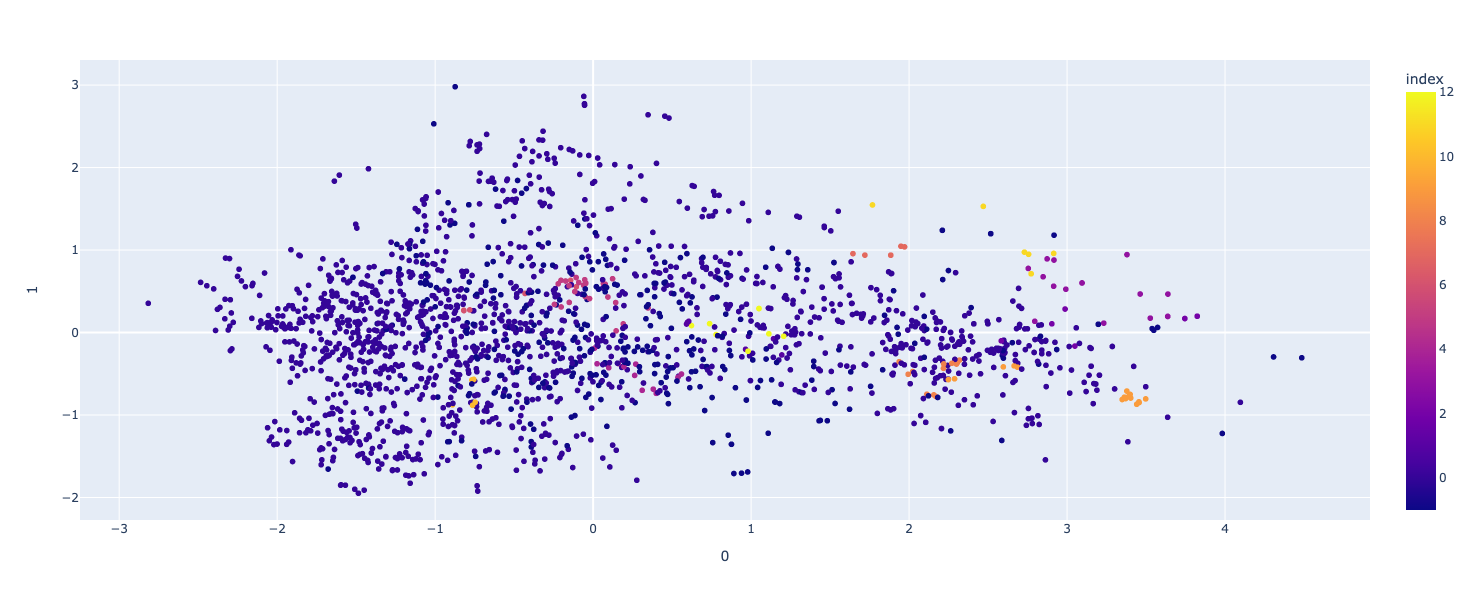

[PCA(n_components=10),
            0         1         2         3         4         5         6  \
 0                                                                          
  0 -0.416843  0.020224 -0.134373 -0.422739  1.117425 -0.911315  0.164074   
  0 -0.097530 -0.118202 -0.357187 -0.543527  1.255056 -0.805280  0.212085   
 -1  0.625395 -0.271304 -0.397123 -0.684761  0.961544 -0.177153 -0.100850   
 -1  0.342195 -0.167423 -0.531378 -0.752558  0.705333 -0.105400 -0.016465   
 -1  0.695850 -0.326762 -0.653742 -0.589246  0.565728 -0.154238 -0.030492   
 ..       ...       ...       ...       ...       ...       ...       ...   
  0 -1.111623 -0.414428 -0.023643 -0.313664  0.410218 -0.070886  0.077881   
  0 -0.998532 -0.545552  0.000383 -0.111610  0.517352 -0.168875  0.210913   
  0 -1.277212 -0.721373 -0.091816 -0.079679  0.523651 -0.172907  0.196826   
  0 -1.468588  0.338654  1.042100  0.610929 -1.223327 -0.314665 -0.240865   
  0 -1.471560  0.410122  1.025410  0.720912 -1.259193

In [150]:
std_func.pca_visualize_2d(doc_vec, pd.DataFrame(clustering.labels_))

In [23]:
model_w.wv.most_similar(positive =['ibm'])

[('dell', 0.8513152003288269),
 ('microsoft', 0.8470609188079834),
 ('vmware', 0.8255583643913269),
 ('hpe', 0.8224751353263855),
 ('cisco', 0.8033583760261536),
 ('packard', 0.8021493554115295),
 ('hewlett', 0.8001822233200073),
 ('sap', 0.7618586421012878),
 ('northrop', 0.7528791427612305),
 ('grumman', 0.7433626651763916)]

The numer of features is actually the number of dimensions, so there are 300 "topics" in this space currently. We'll reduce that before moving forward.

In [21]:
# Since its not sparse, PCA should work just fine
multi_index = pd.MultiIndex.from_frame(final.loc[:,["filingDate","CIK", "name"]])
    
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca_embedding = pca.fit_transform(doc_vec)
pca_embedding = pd.DataFrame(pca_embedding, index = multi_index).reset_index()
pca_embedding

,filingDate,CIK,name,0,1,2,3,4,5,6,7,8,9
0,2016-11-21 18:23:28 UTC,2969,NaN,-0.416842,0.020224,-0.134374,-0.422729,1.117422,-0.911318,0.164078,0.082147,0.244678,-0.308087
1,2018-11-20 19:47:42 UTC,2969,NaN,-0.097531,-0.118204,-0.357185,-0.543530,1.255055,-0.805281,0.212094,0.291281,0.215228,-0.268553
2,2016-12-06 22:05:12 UTC,3545,NaN,0.625394,-0.271305,-0.397121,-0.684758,0.961543,-0.177152,-0.100845,0.401583,0.519135,0.405638
3,2017-12-11 22:13:06 UTC,3545,NaN,0.342194,-0.167424,-0.531378,-0.752558,0.705329,-0.105399,-0.016461,0.572199,0.462956,0.435949
4,2018-12-06 21:58:38 UTC,3545,NaN,0.695849,-0.326763,-0.653741,-0.589245,0.565730,-0.154236,-0.030489,0.362370,0.386933,0.306964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2016-12-19 14:14:40 UTC,1674910,NaN,-1.111624,-0.414428,-0.023642,-0.313664,0.410218,-0.070885,0.077880,-0.180405,-0.199243,-0.077608
2044,2017-11-17 17:10:16 UTC,1674910,NaN,-0.998532,-0.545552,0.000384,-0.111609,0.517351,-0.168874,0.210910,-0.084041,0.151529,-0.244610
2045,2018-11-21 17:02:09 UTC,1674910,NaN,-1.277214,-0.721372,-0.091815,-0.079680,0.523651,-0.172906,0.196823,0.009411,0.067043,-0.247568
2046,2019-09-18T21:17:24Z,1713683,NaN,-1.468586,0.338656,1.042100,0.610932,-1.223326,-0.314667,-0.240860,0.252363,-0.443726,0.586616


In [ ]:
data_word2vec = pd.concat([final.loc[:,["filingDate","CIK", "name"]],doc_vec], axis = 1)
delta_word2vec = deltas(final, data_word2vec, model_w.wv.index_to_key)
delta_word2vec

In [24]:
data_word2vec

,filingDate,CIK,name,0,1,2,3,4,5,6,...,990,991,992,993,994,995,996,997,998,999
0,2016-11-21 18:23:28 UTC,2969,NaN,0.023703,0.144850,-0.159633,-0.063674,0.110550,-0.067106,0.003101,...,-0.143594,0.096299,0.082070,-0.262010,0.017210,-0.111774,0.044098,0.069257,0.012540,0.006471
1,2018-11-20 19:47:42 UTC,2969,NaN,0.023353,0.123273,-0.161382,-0.065698,0.064582,-0.062078,-0.005891,...,-0.124681,0.096346,0.069708,-0.262474,0.053164,-0.100390,0.046597,0.093191,0.002270,-0.005885
2,2016-12-06 22:05:12 UTC,3545,NaN,0.005979,0.097758,-0.177626,-0.078089,0.025049,-0.089145,-0.030858,...,-0.084448,0.054754,0.018183,-0.290879,0.066061,-0.043679,0.013495,0.122585,0.006847,-0.002575
3,2017-12-11 22:13:06 UTC,3545,NaN,0.023022,0.096495,-0.158665,-0.080823,0.042373,-0.078653,-0.045246,...,-0.098387,0.050233,0.013050,-0.273518,0.108556,-0.053433,0.016131,0.142819,0.001853,0.019209
4,2018-12-06 21:58:38 UTC,3545,NaN,0.021777,0.091372,-0.185557,-0.054333,0.067185,-0.065556,-0.055892,...,-0.102267,0.050142,0.035674,-0.269403,0.120507,-0.067137,-0.016278,0.125620,0.008741,0.017835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2016-12-19 14:14:40 UTC,1674910,NaN,0.076672,0.091424,-0.041851,-0.034433,0.104226,-0.121860,-0.021574,...,-0.129508,-0.002776,0.021277,-0.281418,0.087532,-0.096096,-0.005397,0.085088,-0.017917,-0.005212
2044,2017-11-17 17:10:16 UTC,1674910,NaN,0.068263,0.097216,-0.094650,-0.023004,0.077952,-0.107444,-0.010496,...,-0.106025,-0.000899,0.048366,-0.281222,0.057242,-0.081703,-0.010510,0.061374,0.015341,0.010517
2045,2018-11-21 17:02:09 UTC,1674910,NaN,0.077265,0.096097,-0.084789,0.002348,0.089179,-0.116914,-0.020680,...,-0.109730,-0.000387,0.043681,-0.268717,0.060265,-0.095206,0.009860,0.059700,0.016993,-0.000978
2046,2019-09-18T21:17:24Z,1713683,NaN,0.036018,0.159773,-0.060282,0.045059,0.189082,-0.247917,0.052228,...,-0.198900,0.006860,0.008129,-0.082448,0.103780,-0.091671,-0.021711,0.075506,-0.072542,0.009106


### doc2vec

In [30]:
from gensim.models import doc2vec
from collections import namedtuple

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(final["coDescription_stopwords"]):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

# Train model (set min_count = 1, if you want the model to work with the provided example data set)

model = doc2vec.Doc2Vec(docs, vector_size = 100, window = 10, min_count = 1, workers = 4)

In [32]:
doc_vec_2 = pd.DataFrame([model.dv[doc] for doc in np.arange(0,len(docs))])
doc_vec_2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-3.051048,0.253475,-0.951298,3.518957,-0.751801,-2.387775,-0.370758,0.348537,0.718760,-1.764036,...,-1.764057,0.307324,0.166119,0.703162,-0.051421,0.269129,-0.586581,0.755735,0.708616,0.808425
1,-1.655112,0.694850,-1.001633,1.523340,-0.759324,-1.898958,-0.112997,1.212084,0.630468,-1.614710,...,-0.898622,0.787086,-0.119582,-0.013321,0.218807,0.570462,-0.174041,0.344321,0.813839,0.074351
2,-0.141264,-1.681212,0.391510,2.711329,0.527538,-0.961517,-1.062484,1.538146,-1.215151,0.497041,...,-1.231325,0.004381,-1.270467,-1.794680,-0.345118,0.133558,-3.775104,-0.050446,0.737989,1.577506
3,0.536905,-1.394027,0.288564,3.026688,0.048039,-0.415095,-0.684334,1.916261,-1.397017,0.243556,...,-0.213026,-0.006994,-1.649310,-1.658854,-0.347259,0.509019,-3.537075,-0.566232,1.507961,2.723496
4,0.662810,-1.337121,0.819483,3.603098,0.725177,-0.613836,-1.507574,1.555855,-1.503769,0.123721,...,-0.896086,-0.401410,-1.336095,-2.706908,-1.521248,0.130104,-3.949862,-0.156999,0.897526,2.664618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,-2.063368,-0.619451,-0.578013,0.905911,-1.311219,-1.389979,-0.920360,-0.665336,-0.270203,0.052091,...,-1.075685,0.794337,-0.369984,-1.490996,0.398029,0.390516,0.810768,0.878884,1.555373,0.944651
2044,-1.421092,0.290334,-0.262481,1.192366,-1.066384,-1.578804,0.174008,0.038281,0.310822,0.447060,...,-1.601981,1.468989,-0.023442,-0.882296,-0.111494,-0.194219,0.367654,0.348402,2.195239,0.500580
2045,-1.069337,-0.158165,-0.019502,1.433486,-0.677953,-2.510392,-0.014346,-0.231630,-0.285932,1.043552,...,-1.675631,0.833476,-0.360580,-0.499222,-0.652417,-0.279180,1.015080,-0.097226,1.868272,0.352241
2046,-1.436986,1.040861,-1.068703,-1.233667,-3.261262,-0.673878,-0.156417,1.493029,-1.027173,-1.885857,...,0.321441,1.922244,-0.862206,0.645308,0.497194,-0.194687,0.969496,0.178638,0.725196,-3.664975


In [38]:
import hdbscan
clusterer = hdbscan.HDBSCAN()
clusterer.fit(doc_vec_2)

HDBSCAN()

In [40]:
clusterer.labels_.max()

13